# Search images with deep learning (torch)

Images are usually very different if we compare them at pixel level but that's quite different if we look at them after they were processed by a deep learning model. We convert each image into a feature vector extracted from an intermediate layer of the network.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Get a pre-trained model

We choose the model described in paper [SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and <0.5MB model size](https://arxiv.org/abs/1602.07360).

In [3]:
import torchvision.models as models
model = models.squeezenet1_0(pretrained=True)
model

c:\python370_x64\lib\site-packages\torchvision\models\squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
c:\python370_x64\lib\site-packages\torchvision\models\squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): Fire(
      (squeeze): Conv2d(128, 32, kerne

The model is stored here:

In [4]:
import os
os.listdir(os.path.join(os.environ.get('USERPROFILE', os.environ.get('HOME', '.')), 
                        ".torch", "models"))

['squeezenet1_0-a815701f.pth']

[pytorch](https://pytorch.org/)'s design relies on two methods *forward* and *backward* which implement the propagation and backpropagation of the gradient, the structure is not known and could even be dyanmic. That's why it is difficult to define a number of layers.

In [5]:
len(model.features), len(model.classifier)

(13, 4)

## Images

We collect images from [pixabay](https://pixabay.com/).

### Raw images

In [6]:
from pyquickhelper.filehelper import unzip_files
if not os.path.exists('simages/category'):
    os.makedirs('simages/category')
files = unzip_files("data/dog-cat-pixabay.zip", where_to="simages/category")
len(files), files[0]

(31, 'simages/category\\cat-1151519__480.jpg')

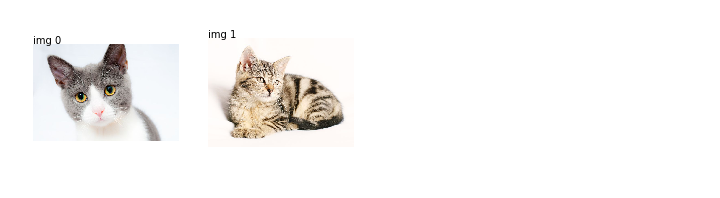

In [7]:
from mlinsights.plotting import plot_gallery_images            
plot_gallery_images(files[:2]);

In [8]:
from torchvision import datasets, transforms

trans = transforms.Compose([transforms.Resize((224, 224)), # essayer avec 224 seulement
                            transforms.CenterCrop(224),
                            transforms.ToTensor()])
imgs = datasets.ImageFolder("simages", trans)
imgs

Dataset ImageFolder
    Number of datapoints: 31
    Root Location: simages
    Transforms (if any): Compose(
                             Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             ToTensor()
                         )
    Target Transforms (if any): None

In [9]:
from torch.utils.data import DataLoader
dataloader = DataLoader(imgs, batch_size=1, shuffle=False, num_workers=1)
dataloader

In [10]:
img_seq = iter(dataloader)
img, cl = next(img_seq)

In [11]:
type(img), type(cl)

(torch.Tensor, torch.Tensor)

In [12]:
array = img.numpy().transpose((2, 3, 1, 0))
array.shape

(224, 224, 3, 1)

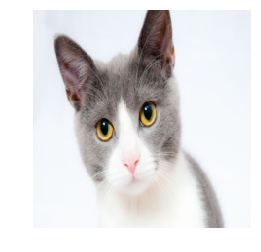

In [13]:
import matplotlib.pyplot as plt
plt.imshow(array[:,:,:,0])
plt.axis('off');

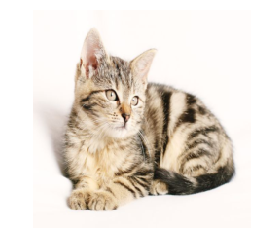

In [14]:
img, cl = next(img_seq)
array = img.numpy().transpose((2, 3, 1, 0))
plt.imshow(array[:,:,:,0])
plt.axis('off');

[torch](https://pytorch.org/) implements optimized function to load and process images.

In [15]:
trans = transforms.Compose([transforms.Resize((224, 224)), # essayer avec 224 seulement
                            transforms.RandomRotation((-10, 10), expand=True),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                           ])
imgs = datasets.ImageFolder("simages", trans)
dataloader = DataLoader(imgs, batch_size=1, shuffle=True, num_workers=1)
img_seq = iter(dataloader)
imgs = list(img[0] for i, img in zip(range(2), img_seq))

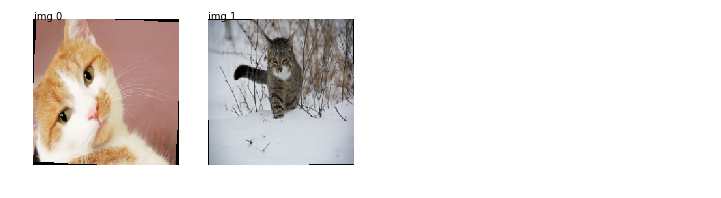

In [16]:
plot_gallery_images([img.numpy().transpose((2, 3, 1, 0))[:,:,:,0] for img in imgs]);

We can multiply the data by implementing a custom [sampler](https://github.com/keras-team/keras/issues/7359) or just concatenate loaders.

In [17]:
from torch.utils.data import ConcatDataset
trans1 = transforms.Compose([transforms.Resize((224, 224)), # essayer avec 224 seulement
                             transforms.RandomRotation((-10, 10), expand=True),
                             transforms.CenterCrop(224),
                             transforms.ToTensor()])
trans2 = transforms.Compose([transforms.Resize((224, 224)), # essayer avec 224 seulement
                             transforms.Grayscale(num_output_channels=3),
                             transforms.CenterCrop(224),
                             transforms.ToTensor()])
imgs1 = datasets.ImageFolder("simages", trans1)
imgs2 = datasets.ImageFolder("simages", trans2)
dataloader = DataLoader(ConcatDataset([imgs1, imgs2]), batch_size=1, 
                        shuffle=True, num_workers=1)
img_seq = iter(dataloader)
imgs = list(img[0] for i, img in zip(range(10), img_seq))

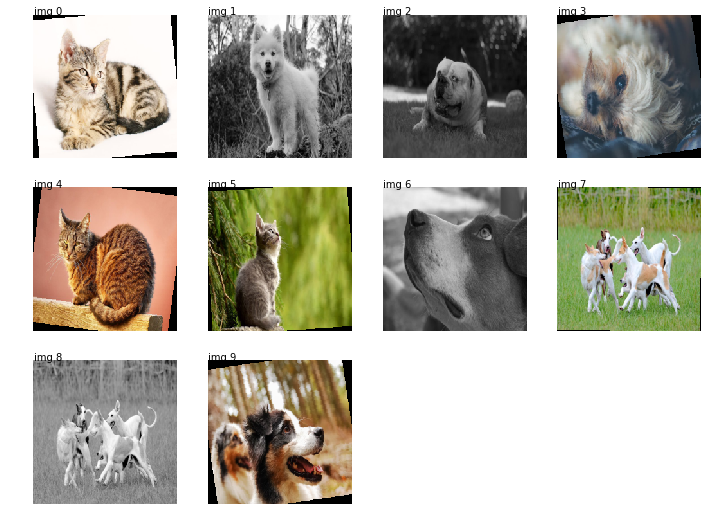

In [18]:
plot_gallery_images([img.numpy().transpose((2, 3, 1, 0))[:,:,:,0] for img in imgs]);

Which leaves 52 images to process out of 61 = 31*2 (the folder contains 31 images).

In [19]:
len(list(img_seq))

52

## Search among images

We use the class ``SearchEnginePredictionImages``.

### The idea of the search engine

The deep network is able to classify images coming from a competition called [ImageNet](http://image-net.org/) which was trained to classify different images. But still, the network has 88 layers which slightly transform the images into classification results. We assume the last layers contains information which allows the network to classify into objects: it is less related to the images than the content of it. In particular, we would like that an image with a daark background does not necessarily return images with a dark background.

We reshape an image into *(224x224)* which is the size the network ingests. We propagate the inputs until the layer just before the last one. Its output will be considered as the *featurized image*. We do that for a specific set of images called the *neighbors*. When a new image comes up, we apply the same process and find the closest images among the set of neighbors.

In [20]:
import torchvision.models as models
model = models.squeezenet1_0(pretrained=True)

c:\python370_x64\lib\site-packages\torchvision\models\squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
c:\python370_x64\lib\site-packages\torchvision\models\squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


The model outputs the probability for each class.

In [21]:
res = model.forward(imgs[1])
res.shape

torch.Size([1, 1000])

In [22]:
res.detach().numpy().ravel()[:10]

array([2.7468913, 4.8511405, 7.9930396, 8.110789 , 6.468867 , 6.414775 ,
       7.73069  , 7.346268 , 7.8933682, 6.4163227], dtype=float32)

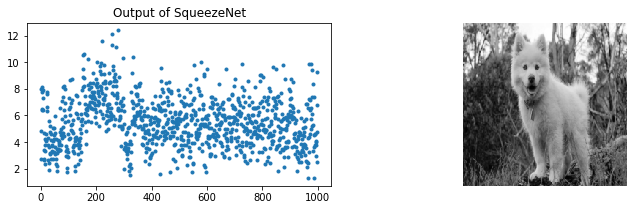

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12,3))
ax[0].plot(res.detach().numpy().ravel(), '.')
ax[0].set_title("Output of SqueezeNet")
ax[1].imshow(imgs[1].numpy().transpose((2, 3, 1, 0))[:,:,:,0])
ax[1].axis('off');

We have features for one image. We build the neighbors, the output for each image in the training datasets.

In [24]:
trans = transforms.Compose([transforms.Resize((224, 224)),
                            transforms.CenterCrop(224),
                            transforms.ToTensor()])
imgs = datasets.ImageFolder("simages", trans)
dataloader = DataLoader(imgs, batch_size=1, shuffle=False, num_workers=1)
img_seq = iter(dataloader)
imgs = list(img[0] for img in img_seq)

In [25]:
all_outputs = [model.forward(img).detach().numpy().ravel() for img in imgs]

In [26]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors()
knn.fit(all_outputs)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

We extract the neighbors for a new image.

In [27]:
one_output = model.forward(imgs[5]).detach().numpy().ravel()

In [28]:
score, index = knn.kneighbors([one_output])
score, index

(array([[19.07566994, 64.99588754, 66.72412277, 68.70732894, 69.73619351]]),
 array([[ 5,  1,  6,  9, 10]], dtype=int64))

We need to retrieve images for indexes stored in *index*.

In [29]:
import os
names = os.listdir("simages/category")
names = [os.path.join("simages/category", n) for n in names]
disp = [names[5]] + [names[i] for i in index.ravel()]
disp

['simages/category\\cat-2603300__480.jpg',
 'simages/category\\cat-2603300__480.jpg',
 'simages/category\\cat-1192026__480.jpg',
 'simages/category\\cat-2882170__480.jpg',
 'simages/category\\cat-2922832__480.jpg',
 'simages/category\\cat-2942887__480.jpg']

We check the first one is exactly the same as the searched image.

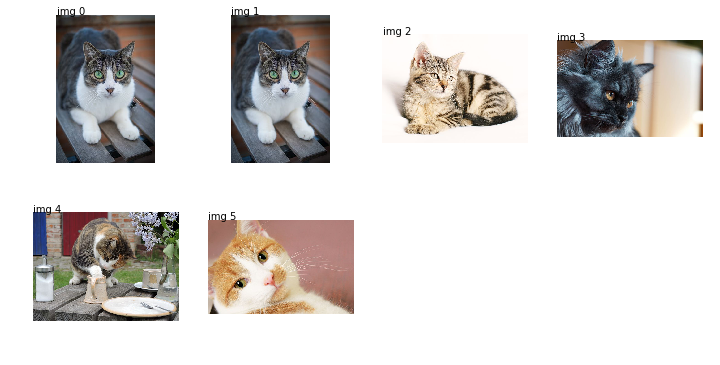

In [30]:
plot_gallery_images(disp);

It is possible to access intermediate layers output however it means rewriting the method forward to capture it: [Accessing intermediate layers of a pretrained network forward?](https://discuss.pytorch.org/t/accessing-intermediate-layers-of-a-pretrained-network-forward/12113/2).

## Going further

The original neural network has not been changed and was chosen to be small (88 layers). Other options are available for better performances. The imported model can be also be trained on a classification problem if there is such information to leverage. Even if the model was trained on millions of images, a couple of thousands are enough to train the last layers. The model can also be trained as long as there exists a way to compute a gradient. We could imagine to label the result of this search engine and train the model on pairs of images ranked in the other.

We can use the [pairwise transform](http://fa.bianp.net/blog/2012/learning-to-rank-with-scikit-learn-the-pairwise-transform/) (example of code: [ranking.py](https://gist.github.com/fabianp/2020955)). For every pair $(X_i, X_j)$, we tell if the search engine should have $X_i \prec X_j$ ($Y_{ij} = 1$) or the order order ($Y_{ij} = 0$). $X_i$ is the features produced by the neural network : $X_i = f(\Omega, img_i)$. We train a classifier on the database:

$$(f(\Omega, img_i) - f(\Omega, img_j), Y_{ij})_{ij}$$

A training algorithm based on a gradient will have to propagate the gradient : $\frac{\partial f}{\partial \Omega}(img_i) - \frac{\partial f}{\partial \Omega}(img_j)$.

**END**